In [1]:
import warnings; warnings.filterwarnings("ignore");
import time
start_time = time.time()

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
#from sklearn import pipeline, model_selection
from sklearn import pipeline, grid_search
#from sklearn.feature_extraction import DictVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import TruncatedSVD
#from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, make_scorer
#from nltk.metrics import edit_distance
from nltk.stem.porter import *
stemmer = PorterStemmer()
#from nltk.stem.snowball import SnowballStemmer #0.003 improvement but takes twice as long as PorterStemmer
#stemmer = SnowballStemmer('english')
import re
#import enchant
import random
random.seed(2016)

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
import os

In [4]:
import seaborn as sns

In [5]:
os.chdir("D:\IRDM")

In [6]:
import matplotlib.pyplot as plt

In [7]:
df_train = pd.read_csv('train.csv', encoding="ISO-8859-1") #update here
df_test = pd.read_csv('test.csv', encoding="ISO-8859-1") #update here
df_pro_desc = pd.read_csv('product_descriptions.csv') #update here
df_attr = pd.read_csv('attributes.csv')
df_brand = df_attr[df_attr.name == "MFG Brand Name"][["product_uid", "value"]].rename(columns={"value": "brand"})
num_train = df_train.shape[0]
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')
df_all = pd.merge(df_all, df_brand, how='left', on='product_uid')
print("--- Files Loaded: %s minutes ---" % round(((time.time() - start_time)/60),2))

--- Files Loaded: 1.48 minutes ---


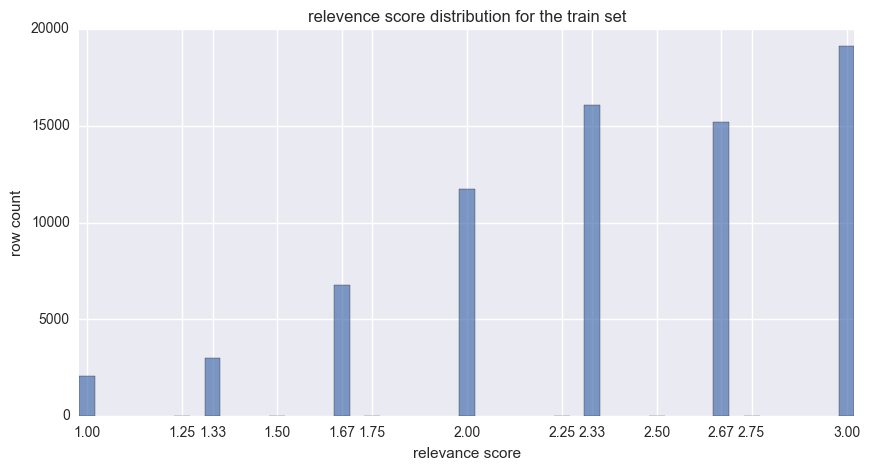

In [10]:
plt.figure(figsize=(10,5))

plt.xticks([1,1.25,1.33,1.5,1.67,1.75,2,2.25,2.33,2.5,2.67,2.75,3])
plt.bar(df_train.relevance.value_counts().index,df_train.relevance.value_counts().values,\
         alpha=0.7,align="center", width = 1/24)
plt.title('relevence score distribution for the train set')
plt.xlabel('relevance score')
plt.ylabel('row count')
plt.show()

In [11]:
stop_w = ['for', 'xbi', 'and', 'in', 'th','on','sku','with','what','from','that','less','er','ing'] #'electr','paint','pipe','light','kitchen','wood','outdoor','door','bathroom'
strNum = {'zero':0,'one':1,'two':2,'three':3,'four':4,'five':5,'six':6,'seven':7,'eight':8,'nine':9}

In [12]:
def str_stem(s): 
    if isinstance(s, str):
        s = re.sub(r"(\w)\.([A-Z])", r"\1 \2", s) #Split words with a.A
        s = s.lower()
        s = s.replace("  "," ")
        s = s.replace(",","") #could be number / segment later
        s = s.replace("$"," ")
        s = s.replace("?"," ")
        s = s.replace("-"," ")
        s = s.replace("//","/")
        s = s.replace("..",".")
        s = s.replace(" / "," ")
        s = s.replace(" \\ "," ")
        s = s.replace("."," . ")
        s = re.sub(r"(^\.|/)", r"", s)
        s = re.sub(r"(\.|/)$", r"", s)
        s = re.sub(r"([0-9])([a-z])", r"\1 \2", s)
        s = re.sub(r"([a-z])([0-9])", r"\1 \2", s)
        s = s.replace(" x "," xbi ")
        s = re.sub(r"([a-z])( *)\.( *)([a-z])", r"\1 \4", s)
        s = re.sub(r"([a-z])( *)/( *)([a-z])", r"\1 \4", s)
        s = s.replace("*"," xbi ")
        s = s.replace(" by "," xbi ")
        s = re.sub(r"([0-9])( *)\.( *)([0-9])", r"\1.\4", s)
        s = re.sub(r"([0-9]+)( *)(inches|inch|in|')\.?", r"\1in. ", s)
        s = re.sub(r"([0-9]+)( *)(foot|feet|ft|'')\.?", r"\1ft. ", s)
        s = re.sub(r"([0-9]+)( *)(pounds|pound|lbs|lb)\.?", r"\1lb. ", s)
        s = re.sub(r"([0-9]+)( *)(square|sq) ?\.?(feet|foot|ft)\.?", r"\1sq.ft. ", s)
        s = re.sub(r"([0-9]+)( *)(cubic|cu) ?\.?(feet|foot|ft)\.?", r"\1cu.ft. ", s)
        s = re.sub(r"([0-9]+)( *)(gallons|gallon|gal)\.?", r"\1gal. ", s)
        s = re.sub(r"([0-9]+)( *)(ounces|ounce|oz)\.?", r"\1oz. ", s)
        s = re.sub(r"([0-9]+)( *)(centimeters|cm)\.?", r"\1cm. ", s)
        s = re.sub(r"([0-9]+)( *)(milimeters|mm)\.?", r"\1mm. ", s)
        s = s.replace("°"," degrees ")
        s = re.sub(r"([0-9]+)( *)(degrees|degree)\.?", r"\1deg. ", s)
        s = s.replace(" v "," volts ")
        s = re.sub(r"([0-9]+)( *)(volts|volt)\.?", r"\1volt. ", s)
        s = re.sub(r"([0-9]+)( *)(watts|watt)\.?", r"\1watt. ", s)
        s = re.sub(r"([0-9]+)( *)(amperes|ampere|amps|amp)\.?", r"\1amp. ", s)
        s = s.replace("  "," ")
        s = s.replace(" . "," ")
        #s = (" ").join([z for z in s.split(" ") if z not in stop_w])
        s = (" ").join([str(strNum[z]) if z in strNum else z for z in s.split(" ")])
        s = (" ").join([stemmer.stem(z) for z in s.split(" ")])
        
        s = s.lower()
        s = s.replace("toliet","toilet")
        s = s.replace("airconditioner","air conditioner")
        s = s.replace("vinal","vinyl")
        s = s.replace("vynal","vinyl")
        s = s.replace("skill","skil")
        s = s.replace("snowbl","snow bl")
        s = s.replace("plexigla","plexi gla")
        s = s.replace("rustoleum","rust-oleum")
        s = s.replace("whirpool","whirlpool")
        s = s.replace("whirlpoolga", "whirlpool ga")
        s = s.replace("whirlpoolstainless","whirlpool stainless")
        return s
    else:
        return "null"

In [13]:
def seg_words(str1, str2):
    str2 = str2.lower()
    str2 = re.sub("[^a-z0-9./]"," ", str2)
    str2 = [z for z in set(str2.split()) if len(z)>2]
    words = str1.lower().split(" ")
    s = []
    for word in words:
        if len(word)>3:
            s1 = []
            s1 += segmentit(word,str2,True)
            if len(s)>1:
                s += [z for z in s1 if z not in ['er','ing','s','less'] and len(z)>1]
            else:
                s.append(word)
        else:
            s.append(word)
    return (" ".join(s))

In [14]:
def segmentit(s, txt_arr, t):
    st = s
    r = []
    for j in range(len(s)):
        for word in txt_arr:
            if word == s[:-j]:
                r.append(s[:-j])
                #print(s[:-j],s[len(s)-j:])
                s=s[len(s)-j:]
                r += segmentit(s, txt_arr, False)
    if t:
        i = len(("").join(r))
        if not i==len(st):
            r.append(st[i:])
    return r

In [15]:
def str_common_word(str1, str2):
    words, cnt = str1.split(), 0
    for word in words:
        if str2.find(word)>=0:
            cnt+=1
    return cnt

In [16]:
def str_whole_word(str1, str2, i_):
    cnt = 0
    while i_ < len(str2):
        i_ = str2.find(str1, i_)
        if i_ == -1:
            return cnt
        else:
            cnt += 1
            i_ += len(str1)
    return cnt

In [17]:
def fmean_squared_error(ground_truth, predictions):
    fmean_squared_error_ = mean_squared_error(ground_truth, predictions)**0.5
    return fmean_squared_error_

RMSE  = make_scorer(fmean_squared_error, greater_is_better=False)

In [18]:
class cust_regression_vals(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, hd_searches):
        d_col_drops=['id','relevance','search_term','product_title','product_description','product_info','attr','brand']
        hd_searches = hd_searches.drop(d_col_drops,axis=1).values
        return hd_searches

In [19]:
class cust_txt_col(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, data_dict):
        return data_dict[self.key].apply(str)

In [20]:
class cust_txt_col(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, data_dict):
        return data_dict[self.key].apply(str)

In [21]:
#comment out the lines below use df_all.csv for further grid search testing
#if adding features consider any drops on the 'cust_regression_vals' class
#*** would be nice to have a file reuse option or script chaining option on Kaggle Scripts ***
df_all['search_term'] = df_all['search_term'].map(lambda x:str_stem(x))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stem(x))
df_all['product_description'] = df_all['product_description'].map(lambda x:str_stem(x))
df_all['brand'] = df_all['brand'].map(lambda x:str_stem(x))
print("--- Stemming: %s minutes ---" % round(((time.time() - start_time)/60),2))

--- Stemming: 16.26 minutes ---


In [22]:
df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title'] +"\t"+df_all['product_description']
print("--- Prod Info: %s minutes ---" % round(((time.time() - start_time)/60),2))

--- Prod Info: 37.84 minutes ---


In [23]:
df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)
df_all['len_of_title'] = df_all['product_title'].map(lambda x:len(x.split())).astype(np.int64)
df_all['len_of_description'] = df_all['product_description'].map(lambda x:len(x.split())).astype(np.int64)
df_all['len_of_brand'] = df_all['brand'].map(lambda x:len(x.split())).astype(np.int64)
print("--- Len of: %s minutes ---" % round(((time.time() - start_time)/60),2))

--- Len of: 38.0 minutes ---


In [24]:
df_all['search_term'] = df_all['product_info'].map(lambda x:seg_words(x.split('\t')[0],x.split('\t')[1]))
#print("--- Search Term Segment: %s minutes ---" % round(((time.time() - start_time)/60),2))
df_all['query_in_title'] = df_all['product_info'].map(lambda x:str_whole_word(x.split('\t')[0],x.split('\t')[1],0))
df_all['query_in_description'] = df_all['product_info'].map(lambda x:str_whole_word(x.split('\t')[0],x.split('\t')[2],0))
print("--- Query In: %s minutes ---" % round(((time.time() - start_time)/60),2))

--- Query In: 38.52 minutes ---


In [25]:
df_all['query_last_word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0].split(" ")[-1],x.split('\t')[1]))
df_all['query_last_word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0].split(" ")[-1],x.split('\t')[2]))
print("--- Query Last Word In: %s minutes ---" % round(((time.time() - start_time)/60),2))

--- Query Last Word In: 38.68 minutes ---


In [26]:
df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))
df_all['ratio_title'] = df_all['word_in_title']/df_all['len_of_query']
df_all['ratio_description'] = df_all['word_in_description']/df_all['len_of_query']
df_all['attr'] = df_all['search_term']+"\t"+df_all['brand']
df_all['word_in_brand'] = df_all['attr'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_all['ratio_brand'] = df_all['word_in_brand']/df_all['len_of_brand']
df_brand = pd.unique(df_all.brand.ravel())

In [27]:
d={}
i = 1000
for s in df_brand:
    d[s]=i
    i+=3
df_all['brand_feature'] = df_all['brand'].map(lambda x:d[x])
df_all['search_term_feature'] = df_all['search_term'].map(lambda x:len(x))
df_all.to_csv('df_all.csv')
#df_all = pd.read_csv('df_all.csv', encoding="ISO-8859-1", index_col=0)
df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']
y_train = df_train['relevance'].values
X_train =df_train[:]
X_test = df_test[:]
print("--- Features Set: %s minutes ---" % round(((time.time() - start_time)/60),2))

--- Features Set: 39.45 minutes ---
